In [3]:
import torch
import sys
import numpy
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as Data

sys.path.append('../')

from src.cars.model import SmallCarsConvVAE128, VAE
from src.cars.data import DataGenerator, define_filenames
from src.utils.denormalize import denormalize

In [36]:
# Set some hyperparameters
LATENT_DIM = 50
MODEL_NAME = "../vae_model_cars.h5"
#MODEL_NAME = "../models/overfit_vae.h5"
NB_EXAMPLES = 10
NOISE_PRC = 0.5

PATH_DATA_CARS = "/misc/DLshare/home/stepcaro/data/stanford_cars"
PATH_DATA_DOGS = "/misc/DLshare/home/stepcaro/data/stanford_dogs2"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"

Load the model and few examples

In [42]:
# Load pretrained model
#model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=500, device = device)
model = SmallCarsConvVAE128(LATENT_DIM)
model.load_state_dict(torch.load(MODEL_NAME))
model.to(device)

#Load few examples
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

train_x_files, _, train_y, _ = define_filenames(
    PATH_DATA_DOGS, PATH_DATA_CARS, NB_EXAMPLES,
    NB_EXAMPLES, NOISE_PRC,
    NOISE_PRC)

train_data = DataGenerator(train_x_files,
                           train_y,
                           transform=transform,
                           image_size=(128, 128))

train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=64,
                               shuffle=False)

for i, (x, y) in enumerate(train_loader):
    x = Variable(x)
    x = x.to(device)
    generated, mu, logvar, _ = model(x, device)
    #generated, mu, logvar = model(x)
    
    if i == 0:
        generated_x = generated
        z_mu = mu.to("cpu").detach().numpy()
        z_logvar = logvar.to("cpu").detach().numpy()
        
    else:
        generated_x = torch.cat((generated_x, generated), 0)
        z_mu = numpy.append(z_mu, mu.to("cpu").detach().numpy(), axis=0)
        z_logvar = numpy.append(z_logvar, logvar.to("cpu").detach().numpy(), axis=0)

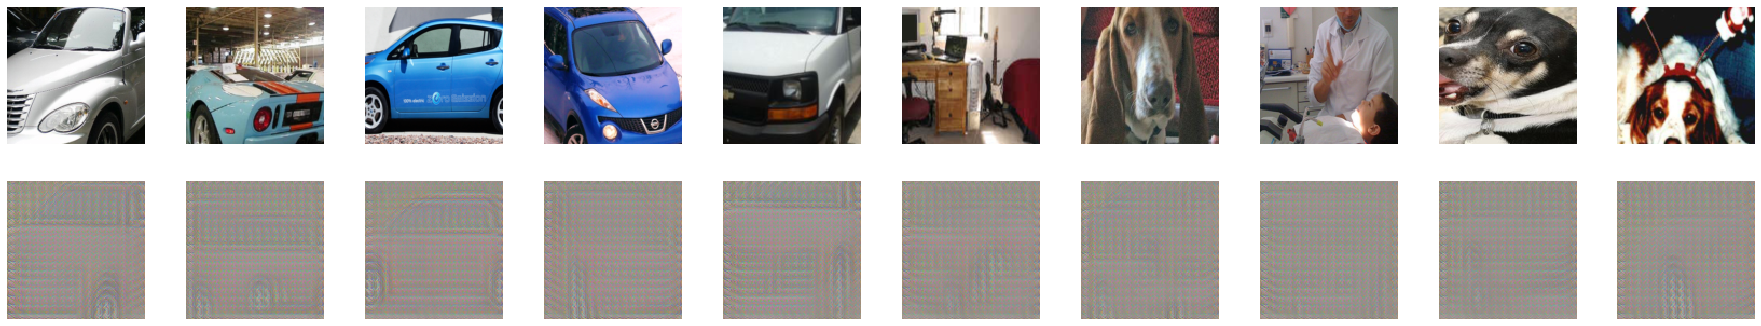

In [45]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

for i in range(20):
    if i < 10:
        image = train_data[i][0].transpose_(0,2)
        image = denormalize(image, MEAN, STD, device).numpy().astype(float)
        axs[i].imshow(image)
        axs[i].axis('off')
    else:
        image = generated_x[i-10].transpose_(0,2)
        image = denormalize(image, MEAN, STD, device).detach().cpu().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

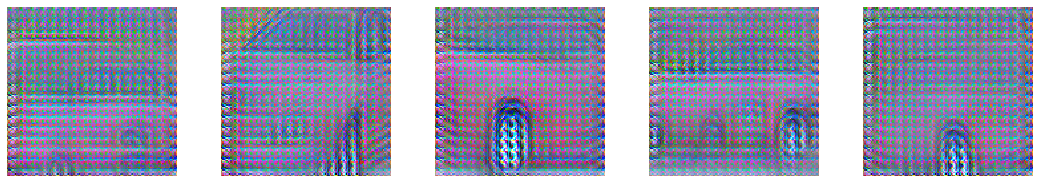

In [51]:
plt.rcParams['figure.figsize'] = [15, 5]

MU = numpy.repeat(0, LATENT_DIM)
SIGMA = numpy.diag(numpy.repeat(1, LATENT_DIM))
dt_sim = numpy.random.multivariate_normal(mean=MU, cov=SIGMA, size=32)

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

x = torch.from_numpy(dt_sim).float().to(device)
generated = model.decode(x)

for i in range(5):
    image = generated[i].transpose_(0,2).detach().numpy()
    axs[i].imshow(image)
    axs[i].axis('off')

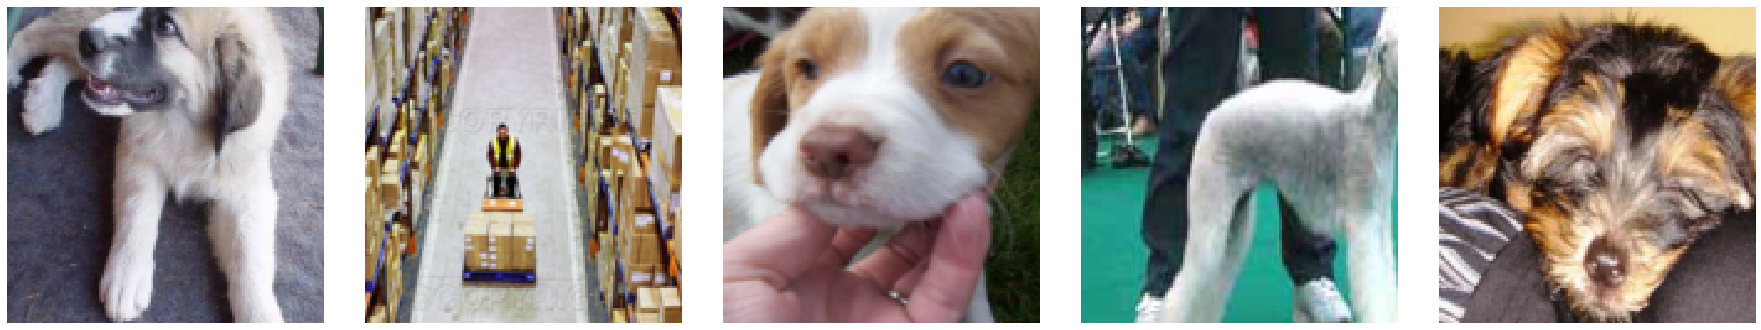

In [24]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(1, 5)
fig.tight_layout()
axs = axs.ravel()

for i in range(5):
    image = train_data[i+5][0].transpose_(0,2)
    image = denormalize(image, MEAN, STD, device).numpy().astype(float)
    axs[i].imshow(image)
    axs[i].axis('off')

In [35]:
cutoff = int(NB_EXAMPLES/2)

print(numpy.mean(numpy.mean(z_mu[0:cutoff], 0)))
print(numpy.mean(numpy.mean(z_mu[cutoff:NB_EXAMPLES], 0)))
print(numpy.mean(numpy.mean(numpy.exp(z_logvar[0:cutoff]), 0)))
print(numpy.mean(numpy.mean(numpy.exp(z_logvar[cutoff:NB_EXAMPLES]), 0)))

#print(numpy.mean(z_mu[0:cutoff], 0))
#print(numpy.mean(z_mu[cutoff:NB_EXAMPLES], 0))

-0.001352506
0.0013525091
0.26295298
0.36304542


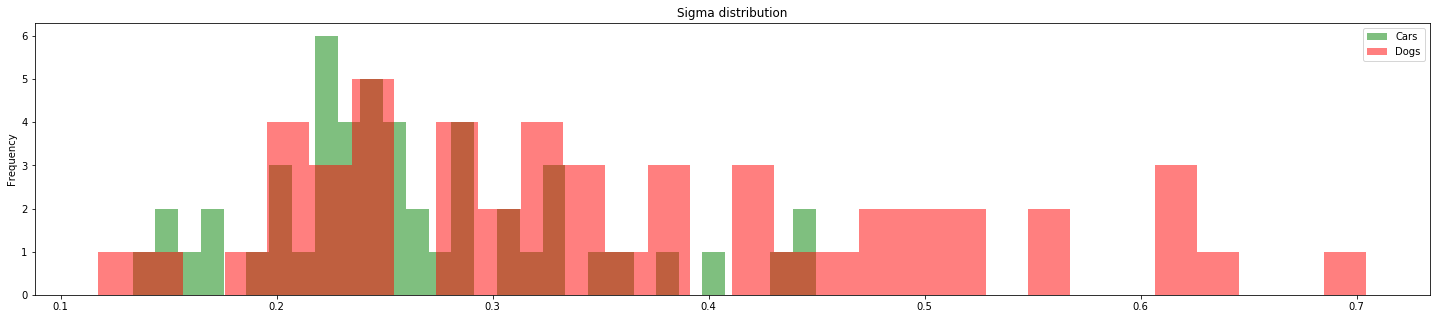

In [26]:
logvar_cars = numpy.mean(numpy.exp(z_logvar[0:cutoff]), axis=1)
logvar_dogs = numpy.mean(numpy.exp(z_logvar[cutoff:NB_EXAMPLES]), axis=1)
kwargs = dict(alpha=0.5, bins=30)
plt.hist(logvar_cars, **kwargs, color='g', label='Cars')
plt.hist(logvar_dogs, **kwargs, color='r', label='Dogs')
plt.gca().set(title='Sigma distribution', ylabel='Frequency')
plt.legend()